In [ ]:
%load_ext autoreload
%autoreload 2

In [8]:
#REFRESH - RELOAD MODULES
import importlib
import add_prices_to_oip
import get_oip_1p
importlib.reload(add_prices_to_oip)
importlib.reload(get_oip_1p)


<module 'get_oip_1p' from 'c:\\Users\\John DeForest\\Desktop\\stonx\\get_oip_1p.py'>

In [9]:
# dr1.py
from get_oip_1p import get_oip_1p
from add_prices_to_oip import add_prices_to_oip
from remove_failed_tickers import remove_failed_tickers
from add_relative_prices import add_relative_prices
from add_return_columns import add_return_columns
from train_rf_forward_return_model import train_rf_forward_return_model
from plot_predicted_vs_actual import plot_predicted_vs_actual
from run_rf_model_for_all_forward_returns import run_rf_model_for_all_forward_returns
import pandas as pd
import time
from single_positrader import single_positrader
from simulate_all_tickers import simulate_all_tickers
import matplotlib.pyplot as plt

In [11]:
#5/01/22 - 23
oiurl = 'http://openinsider.com/screener?s=&o=&pl=&ph=&ll=&lh=&fd=-1&fdr=05%2F01%2F2022+-+05%2F01%2F2023&td=0&tdr=&fdlyl=&fdlyh=&daysago=&xp=1&vl=&vh=&ocl=&och=&sic1=-1&sicl=100&sich=9999&grp=0&nfl=&nfh=&nil=&nih=&nol=&noh=&v2l=&v2h=&oc2l=&oc2h=&sortcol=0&cnt=1000&page=1'
oip = get_oip_1p(oiurl)
oip = oip.drop(columns=['1d','1w','1m','6m','δown'])
print(oip.head())
print('number of rows:', len(oip))
tickers = oip["ticker"].unique().tolist()
print(oip.columns)

     x         filing_date trade_date ticker  \
0    D 2023-05-01 21:31:53 2023-04-28   USGO   
1    D 2023-05-01 20:33:46 2023-05-01   BANC   
2  NaN 2023-05-01 19:51:48 2023-05-01     PI   
3   DM 2023-05-01 19:29:20 2023-04-26   FOMC   
4  NaN 2023-05-01 19:08:00 2023-04-27   KREF   

                         company_name          insider_name          title  \
0                U.S. Goldmining Inc.  Bukacheva Aleksandra            Dir   
1            Banc of California, Inc.         Wolff Jared M      Pres, CEO   
2                          Impinj Inc          Sanghi Steve            Dir   
3                Fomo Worldwide, Inc.       Grover Vikram P  CEO, Dir, 10%   
4  Kkr Real Estate Finance Trust Inc.       Salem Matthew A            CEO   

     trade_type      qty    owned      value  trade_price  d_own_plus%  
0  P - Purchase     1000     1000     9150.0         9.15          NaN  
1  P - Purchase     6769   273252    75118.0        11.10          3.0  
2  P - Purchase    2350

In [5]:
#TODO: count/store/assess failed ticker downloads: delisted/etc - how many? pattern? problem?
oip_with_prices,invalid_tickers,failedtickers,failed_dict = add_prices_to_oip(oip)
failedtickersunique = list(set(failedtickers))
print(f'failed instances of ticker downloads: {len(failedtickers)} for {len(failedtickersunique)} unique tickers. \n This is {len(failedtickersunique)/len(tickers)*100:.2f}% of all tickers. And this is {len(failedtickers)/len(oip)*100:.2f}% of all insider trades in the OIP.')
#print('failed tickers:', failedtickersunique)
oip_clean = remove_failed_tickers(oip_with_prices, failedtickersunique)


1 Failed download:
['FOMC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CSTR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SMMF']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HMNF']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CVCY']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BECN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SCWX']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['NEP']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BCOV']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AHNR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AULT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HHC']: YFTzMissingErro

failed instances of ticker downloads: 302 for 65 unique tickers. 
 This is 15.70% of all tickers. And this is 30.20% of all insider trades in the OIP.
Removed 151 rows with failed tickers.


In [6]:
failed_df = pd.DataFrame.from_dict(failed_dict, orient='index')

# Step 2: Reset index to bring tickers into a column
failed_df.reset_index(inplace=True)
failed_df.rename(columns={'index': 'ticker'}, inplace=True)
#for each ticker, get from oip (other df) the trade_price value (the first instance since there may be many instances)
failed_df['trade_price'] = None
failed_df['trade_date'] = None
failed_df['qty'] = None

# Step 3: For each row in failed_df, fetch first matching row in oip
for i, row in failed_df.iterrows():
    ticker = row['ticker']
    match = oip[oip['ticker'] == ticker]
    if not match.empty:
        first = match.iloc[0]
        failed_df.at[i, 'trade_price'] = first.get('trade_price')
        failed_df.at[i, 'trade_date'] = first.get('trade_date')
        failed_df.at[i, 'qty'] = first.get('qty')


# Step 3: Write to CSV in current working directory
failed_df.to_csv("failed_log2.csv", index=False)

# Optional: Display preview in notebook
failed_df.head()

,ticker,lvl,mdate,mprice_date,company_name,error,trade_price,trade_date,qty
0,FOMC,itermebuyprice2,2023-04-27 16:27:32,2023-05-02,"Fomo Worldwide, Inc.",index -2 is out of bounds for axis 0 with size 0,0.19,2023-04-26 00:00:00,5548815
1,CSTR,itermebuyprice2,2023-05-02 17:16:51,2023-04-25,"Capstar Financial Holdings, Inc.",index -2 is out of bounds for axis 0 with size 0,13.37,2023-05-01 00:00:00,5000
2,SMMF,itermebuyprice2,2023-05-02 16:41:26,2023-04-28,"Summit Financial Group, Inc.",index -2 is out of bounds for axis 0 with size 0,19.62,2023-05-01 00:00:00,3000
3,HMNF,itermebuyprice2,2023-03-25 15:43:09,2023-05-02,Hmn Financial Inc,index -2 is out of bounds for axis 0 with size 0,18.35,2023-04-27 00:00:00,1054
4,CVCY,itermebuyprice2,2023-04-29 14:01:19,2023-04-28,Central Valley Community Bancorp,index -2 is out of bounds for axis 0 with size 0,14.73,2023-04-28 00:00:00,2000


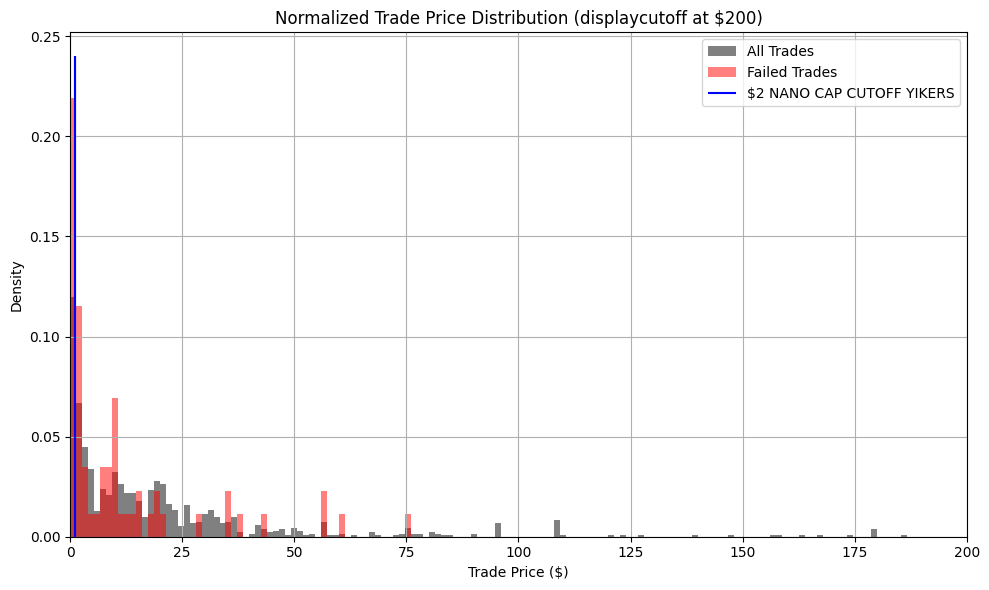

⚠️ Failed tickers with trade_price > $200:


,ticker,trade_price,qty,trade_date
60,HARP,1000.0,10000,2023-03-23 00:00:00


⚠️ All oip tickers with trade_price > $200:


,ticker,trade_price,qty
335,LMT,495.17,506
448,FDX,230.75,1080
576,FDX,232.88,830
690,RBBN,970.00,5000
911,HARP,1000.00,10000
920,DG,202.00,3550


📊% ALL YF insider tickers w 2023ish tradeprice under $2:       21.400%
❌% of FAILED (YF couldnt find) YF insider tickers w 2023ish tradeprice under $2:    44.615%
✅% of SUCCEED (YF did find) YF insider tickers w 2023ish tradeprice under $2:   17.550%
NOTE: DOES NOT MEAN ANYTHING ABOUT PRICE MOVEMENT, JUST DATA RETRIEVAL


In [24]:
oip_trimmed = oip[['ticker', 'trade_price', 'qty']].copy()
import matplotlib.pyplot as plt

displaycutoff = 200

#NANO/MICROCAP cutoff price of stock value:
nanocutoff = 2

# Normalize histograms: density=True makes area under curve = 1
plt.figure(figsize=(10,6))
# Plot all trades (normalized)
plt.hist(oip_trimmed['trade_price'], bins=750, density=True, color='grey', alpha=1.0, label='All Trades')
# Plot failed trades (normalized)
plt.hist(failed_df['trade_price'], bins=750, density=True, color='red', alpha=0.5, label='Failed Trades')
#plot vertical line in blue at x=1
plt.vlines((1,1),(0),(.24),colors='blue',label=f'${nanocutoff} NANO CAP CUTOFF YIKERS')
plt.xlabel('Trade Price ($)')
plt.ylabel('Density')
plt.title(f'Normalized Trade Price Distribution (displaycutoff at ${displaycutoff})')
plt.xlim(0, displaycutoff)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Print failed trades with price > 500
high_price_failed = failed_df[failed_df['trade_price'] > displaycutoff][['ticker', 'trade_price', 'qty', 'trade_date']]
print(f"⚠️ Failed tickers with trade_price > ${displaycutoff}:")
display(high_price_failed)
high_price_oip =  oip_trimmed[oip_trimmed['trade_price'] > displaycutoff][['ticker', 'trade_price', 'qty']]
print(f"⚠️ All oip tickers with trade_price > ${displaycutoff}:")
display(high_price_oip)

oip_trimmed['ticker'] = oip_trimmed['ticker'].astype(str)
failed_tickers = failed_df['ticker'].astype(str).unique()

# Create succeed_df (those not in failed_df)
succeed_df = oip_trimmed[~oip_trimmed['ticker'].isin(failed_tickers)]

# Fractions
frac_all_under1 = (oip_trimmed['trade_price'] < nanocutoff).mean()
frac_failed_under1 = (failed_df['trade_price'] < nanocutoff).mean()
frac_succeed_under1 = (succeed_df['trade_price'] < nanocutoff).mean()

# Print results
print(f"📊% ALL YF insider tickers w 2023ish tradeprice under ${nanocutoff}:       {frac_all_under1:.3%}")
print(f"❌% of FAILED (YF couldnt find) YF insider tickers w 2023ish tradeprice under ${nanocutoff}:    {frac_failed_under1:.3%}")
print(f"✅% of SUCCEED (YF did find) YF insider tickers w 2023ish tradeprice under ${nanocutoff}:   {frac_succeed_under1:.3%}")
print("NOTE: DOES NOT MEAN ANYTHING ABOUT PRICE MOVEMENT, JUST DATA RETRIEVAL")


In [7]:
oip_with_prices_relative = add_relative_prices(oip_clean)
print(oip_with_prices_relative.head(1))
print(oip_with_prices_relative.columns)

oip_with_prices_relative = add_return_columns(oip_with_prices_relative)
print((oip_with_prices_relative.iloc[0]))#.to_string(index=False))

Extracting prices: 100%|██████████| 848/848 [00:02<00:00, 315.78it/s]

   x         filing_date trade_date ticker          company_name  \
0  D 2023-05-01 21:31:53 2023-04-28   USGO  U.S. Goldmining Inc.   

           insider_name title    trade_type   qty  owned  ...    p_p4_td  \
0  Bukacheva Aleksandra   Dir  P - Purchase  1000   1000  ...  16.110001   

   p_p5_td  p_p6_td  p_p10_td  p_p25_td  p_p50_td p_p75_td  p_p125_td  \
0    14.81    14.64     14.35     13.65     13.42     9.91       4.94   

   p_p175_td p_p225_td  
0      7.055     5.302  

[1 rows x 48 columns]
Index(['x', 'filing_date', 'trade_date', 'ticker', 'company_name',
       'insider_name', 'title', 'trade_type', 'qty', 'owned', 'δown', 'value',
       '1d', '1w', '1m', '6m', 'mebuydate', 'trade_price', 'd_own_plus%',
       'filing_price', 'mebuy_price', 'mebuy_pricedateQ', 'p_m1_td', 'p_m2_td',
       'p_m3_td', 'p_m4_td', 'p_m5_td', 'p_m6_td', 'p_m10_td', 'p_m25_td',
       'p_m50_td', 'p_m75_td', 'p_m125_td', 'p_m175_td', 'p_m225_td',
       'p_p1_td', 'p_p2_td', 'p_p3_td', 'p_p4

In [8]:
#model training for 5d forward return!
model_5d, X_train_5d, y_train_5d, y_pred_5d = train_rf_forward_return_model(oip_with_prices_relative, forward_return_col='r_p5_td')

#NOTE OPT: 5dfwd pred vs actual:
#plot_predicted_vs_actual(y_train_5d, y_pred_5d, title="5D Forward Return Prediction")

📈 R²: 0.9245
📉 RMSE: 0.0301
🔢 Samples used: 797

🌲 Feature Importances:
r_m225_td      0.114009
r_m75_td       0.095174
r_m25_td       0.076431
r_m6_td        0.074605
r_m50_td       0.071299
r_m175_td      0.067221
r_m2_td        0.067069
r_m4_td        0.062772
r_m125_td      0.059263
qty            0.057764
r_m5_td        0.048522
r_m10_td       0.047187
r_m3_td        0.045191
d_own_plus%    0.039272
value          0.037292
owned          0.026553
r_m1_td        0.010376
dtype: float64


In [9]:
#model training for ALL forward returns!
forward_cols = [col for col in oip_with_prices_relative.columns if col.startswith("r_p")]
modelsmetrics,models_dict = run_rf_model_for_all_forward_returns(oip_with_prices_relative, forward_cols)


--- Training model for: r_p1_td ---
📈 R²: 0.8951
📉 RMSE: 0.0214
🔢 Samples used: 797

🌲 Feature Importances:
qty            0.219521
r_m2_td        0.100210
r_m75_td       0.088163
r_m3_td        0.075819
r_m125_td      0.064376
r_m4_td        0.055753
r_m6_td        0.055198
r_m175_td      0.049092
r_m25_td       0.048618
value          0.043304
r_m50_td       0.039116
owned          0.035869
r_m10_td       0.035313
r_m225_td      0.034284
r_m5_td        0.030913
d_own_plus%    0.016017
r_m1_td        0.008433
dtype: float64
R²: 0.8951
RMSE: 0.0214
Precision (Direction): 0.9282
Recall (Direction): 0.9557
F1 Score (Direction): 0.9417

--- Training model for: r_p2_td ---
📈 R²: 0.9061
📉 RMSE: 0.0233
🔢 Samples used: 797

🌲 Feature Importances:
qty            0.154615
r_m75_td       0.081778
r_m50_td       0.079979
r_m2_td        0.075236
r_m6_td        0.071003
r_m4_td        0.067657
r_m3_td        0.065468
r_m125_td      0.060335
r_m25_td       0.057713
r_m175_td      0.051601
owned    

In [ ]:
#NOTE OPT: fwd window choosing testing
from fwd_window_scoring import scoreandrank
w_r2 = 0.35
w_rmse = 0.2
w_precision = 0.35 # NOTE: most important - no false positives = NEED HI precision
w_recall = 0.1
ranked_models_df = scoreandrank(modelsmetrics, w_r2=w_r2, 
                                w_rmse=w_rmse, w_precision=w_precision, w_recall=w_recall)
print(ranked_models_df)
#NOTE okay r_p5_td seems best - MANUAL PICK

In [ ]:
# need ticker_counts for eval trade freq choicing
ticker_counts = oip_with_prices_relative['ticker'].value_counts().sort_values(ascending=False)
print(ticker_counts[:20]) # for indiv testing

In [ ]:
single_test_ticker = 'FYBR'  # Example ticker, w several insider trades

results = single_positrader(
    df=oip_with_prices_relative,
    ticker=single_test_ticker,
    ticker_counts = ticker_counts,
    model=models_dict['r_p5_td'],
    forward_price_col='p_p5_td',
    return_col='r_p5_td',
    buymag=100,
    plot=False
)
print(results)

In [ ]:
#main strat (verification - internal testing)
summary_df = simulate_all_tickers(
    df=oip_with_prices_relative,
    ticker_counts = ticker_counts,
    model=model_5d,
    forward_price_col='p_p5_td',
    return_col='r_p5_td'
)

print('=== END OF INTERNAL TESTING ===')
print('internal testing time(s):', time.time() - runtime_start)
#INTERNAL TESTING ABOVE


#EXTERNAL TESTING BELOW:
print("=== START OF EXTERNAL TESTING ===")
#VALIDATION TESTING : 4/9/2024 to 4/30/2024 
# insider trades OIP, using model trained on 2023 data (see internal, above)
newurl = 'http://openinsider.com/screener?s=&o=&pl=&ph=&ll=&lh=&fd=-1&fdr=04%2F09%2F2024+-+04%2F30%2F2024&td=0&tdr=&fdlyl=&fdlyh=&daysago=&xp=1&vl=&vh=&ocl=&och=&sic1=-1&sicl=&sich=&grp=0&nfl=&nfh=&nil=&nih=&nol=&noh=&v2l=&v2h=&oc2l=&oc2h=&sortcol=0&cnt=500&page=1'
newoip = get_oip_1p(newurl)
newoip_with_prices,newfailedtickers = add_prices_to_oip(newoip)
newfailedtickersunique = list(set(newfailedtickers))
newoip_clean = remove_failed_tickers(newoip_with_prices, newfailedtickersunique)
newoip_with_prices_relative = add_relative_prices(newoip_clean)
print(newoip_with_prices_relative.head(1))
print(newoip_with_prices_relative.columns)
newoip_with_prices_relative = add_return_columns(newoip_with_prices_relative)
print((newoip_with_prices_relative.iloc[0]))#.to_string(index=False))
newticker_counts = newoip_with_prices_relative['ticker'].value_counts().sort_values(ascending=False)
print(newticker_counts[:20]) #frequent insider trades
results_new = simulate_all_tickers(
    df=newoip_with_prices_relative,
    ticker_counts = newticker_counts,
    model=model_5d,
    forward_price_col='p_p5_td',
    return_col='r_p5_td',
    plot=False  # Optional
)
print(results_new)
print(results_new.describe())
print(f'#trades ex: {sum(results_new['num_trades'])}') #checks out
#print the number of tickers that had pnl greater than 0
print(f'#tickers w POS pnl: {len(results_new[results_new['pnl'] > 0])}')
print(f'#tickers w NEG pnl: {len(results_new[results_new['pnl'] < 0])}')
print(f'#tickers w ZERO pnl: {len(results_new[results_new['pnl'] == 0])}')
#print num of trades that contributed to positive return (cant tell from here within-ticker up/downs)
#print sum of num_trades column of results_new iff pnl > 0:
print(f'#trades contrib2 POS ret: {results_new[results_new['pnl'] > 0]['num_trades'].sum()}')
print(f'#trades contrib2 NEG ret: {results_new[results_new['pnl'] < 0]['num_trades'].sum()}')
print(f'#trades contrib2 ZERO ret: {results_new[results_new['pnl'] == 0]['num_trades'].sum()}')

print("=== END OF EXTERNAL TESTING ===")
runtime_end = time.time()
print(f"Total runtime: {runtime_end - runtime_start:.2f} seconds")